# Introduction
A neural network, sometimes also referred as multi layer perceptron, is basically an algorithm that is used to learn more sophisticated features than what a perceptron can learn. It does this by using multiple layers of perceptrons. The image below explains a little about the architecture it follows
<center> **Neural Network** </center>
![Neural Network architecture](NN_demo_image.jpeg "A Neural Network")

The inputs are given to the *input layer*, the hidden layers simply perform a weighed sum of the outputs of the previous layer, add it with a bias and then pass it through a function. Usually, the same activation function is used for every neuron in one layer. If you've gone through my perceptron notebook (link [here](https://github.com/TheProjectsGuy/Blogger/blob/master/Projects/Hand_Gesture_Recognition/Trial2/MachineLearningSolutions/Perceptron/Jupyter_Notebook/Perceptron_model_5_fingers_detection.ipynb)), you can perceive that every neuron is basically acting like a perceptron (hence the name _multi layer perceptron_). All the neurons are connected by a _weight_, this is used to perform a weighed sum (same as in the perceptron)

Basically to summarize what happens in a neural network, 
- *Neurons of input layer*
   - Simply take the inputs
- *Neurons of hidden layers*
   - Take values of the previous payer
   - Perform a weighed sum
   - Add a bias
   - Pass the result through a function (known as the activation function of the layer)
   - Store the output
- *Neurons of output layer*
   - Take the values of the previous layer
   - Perform a weighed sum
   - Add a bias
   - Pass the result through a function
   - Present the output. This is the _output of the neural network_.

The above points are exactly what we do in forward propagation through the neural network. In order to learn the proper weights connecting the neurons from layer _l_ to _l + 1_, we perform something called as _Back Propagation_. In this, we apply the concept of gradient descent, chain rule of differentiation and a little matrice calculus to obtain the changes we need to make.

In the [perceptron](https://github.com/TheProjectsGuy/Blogger/blob/master/Projects/Hand_Gesture_Recognition/Trial2/MachineLearningSolutions/Perceptron/Jupyter_Notebook/Perceptron_model_5_fingers_detection.ipynb) algorithm, we used the entire training set in order to take only one step, and then took several iterations of it. Here, we'll try something different. We'll divide the training set into many smaller training sets (known as batches), and then perform training on batches. This is known as _mini batch gradient descent_. We'll program that too. We'll not use any of the modern programming frameworks like [_tensorflow_](https://www.tensorflow.org/), [_scikit learn_](http://scikit-learn.org/stable/index.html), or anything. We'll make one from the basics to understand how everything works in a simple neural network. So let's get started

## _Hand Gesture Recognition_
Here are the different hand gestures we'll be working with. For this, we'll follow the same thing we did in the perceptron algorithm. We'll train a neural network to detect the five finger gesture.
<center> **Gestures** </center>
![Gestures](Hand_Gesture_Classes_5_Finger.jpg)
Usually, there's an intuition in deciding the number of layers. We can attach them wth minor features but we're free to explore possibilities.

Let's start by importing the needed files

In [1]:
# Importing libraries
import numpy as np                     # For optimised mathematical operations
from matplotlib import pyplot as plt   # For plotting the results 

np.random.seed(2)       # Just so that we get the same random number every time we run the program

## Importing and shuffling data
Now we're dealing with a supervised learning problem (labelled dataset needed). For this neural network, we have a dataset consisting of binary images (every pixel is either white or black). The images are actually 235 by 190, but they're shrinked to 47 by 38 size, so that we have smaller number of input featres to deal with (1786 input features). Fortunately, we have a **.npy** file for inputs and labelled outputs, so all we need to do is to load the binary data file.
Usually, we are unaware of the source of data, so it's always a good idea to shuffle it. This is done so that we obtain a uniform distribution of data, this improves overall performance. The dataset we are using has about a 50-50 distribution (50 % images are images of 5 fingers), shuffling it will ensure uniform distribution.

### Splitting data into buckets
To train and evaluate the model, we usually split the data into three groupt (buckets), **train**, **dev** and **test** sets. Their purpose is stated below

Bucket name | Purpose
-----|------
**Train** | Used to train a model
**Dev** | Used to compare different models (also known as the cross validation set)
**Test** | Used to perform the final test of the model

While training, we split the training set into various parts (batches), let us implement a function for that as well.

So first, *loading the dataset*

In [17]:
# Load the dataset
def load_dataset(dataset_dir_name="Data", x_name="X.npy",
                 y_name="Y_one_hot_encoded.npy", one_hot_index=0, shuffle_data=True, normalize_data=True):
    """
    Loads a dataset stored as a .npy file
    :param dataset_dir_name: Name of the folder in which data is
    :param x_name: Name of file which contains inputs (with .npy extension)
    :param y_name: Name of file which contains outputs (with .npy extension)
    :param one_hot_index: The index you're training for (pass -1 for passing raw output file), should be >= -1
    :param shuffle_data: Shuffle the data
    :param normalize_data: Normalize the input data
    :return:
        X, Y
        X -> Inputs
        Y -> Outputs
        The output will be shuffled if shuffle_data is True, else it won't be shuffled
    """
    # Load the dataset from memory
    X = np.load("{main_root}/{f_name}".format(main_root=dataset_dir_name,
                                                 f_name=x_name))
    print("DATA DEBUG : Inputs shape is {in_shape}".format(in_shape=X.shape))
    if one_hot_index == -1:
        # Parse the entire dataset as it is
        Y = np.load("{main_root}/{f_name}".format(main_root=dataset_dir_name,
                                                     f_name=y_name))
    elif one_hot_index >= 0:
        # Get the particular one_hot_encoded row
        Y_one_hot = np.load("{main_root}/{f_name}".format(
            main_root=dataset_dir_name, f_name=y_name
        ))
        Y = np.array(Y_one_hot[one_hot_index, :].reshape((1, -1)))
    else:
        raise IndexError("The index {ind_number} is an illegal index".format(ind_number=one_hot_index))
    print("DATA DEBUG : Output shape is {out_shape}".format(out_shape=Y.shape))
    if normalize_data:
        X = X / 255
    if shuffle_data:
        X, Y = shuffle_dataset(X, Y)
    Y_true_p = Y.nonzero()[1].reshape(1, -1).shape[1] / Y.shape[1]
    print("DATA DEBUG : {tp}% data is true".format(tp=Y_true_p * 100))
    return X, Y

Now, a function to shuffle the dataset

In [3]:
# Shuffle the dataset
def shuffle_dataset(X, Y):
    """
    Shuffles the dataset (shuffle columns) and returns it
    :param X : Inputs
    :param Y : Outputs
    :return:
        tuple(X, Y)
        X, Y with their columns shuffled
    """
    buffer_data = np.row_stack((X, Y))                        # Unify the inputs and outputs of data
    buffer_data = buffer_data.T                               # columns -> rows
    np.random.shuffle(buffer_data)                            # Performs row shuffling
    buffer_data = buffer_data.T                               # rows -> columns
    X = buffer_data[0:X.shape[0], :]                          # Retrieve X
    Y = buffer_data[X.shape[0]:X.shape[0] + Y.shape[0], :]    # Retrieve Y
    return X, Y

Now, a function to split the dataset into **train**, **dev** and **test** sets

In [4]:
# Split the dataset
def split_train_dev_test(X, Y, sizes=(2500, 136, 136)):
    """
    Split the dataset into train, dev and test sets
    :param X: Inputs
    :param Y: Outputs
    :param sizes: Distribution tuple
    :return: Dictionary
        "train" : (X_train, Y_train)
        "dev" : (X_dev, Y_dev)
        "test" : (X_test, Y_test)
    """
    # Split the dataset
    # Train sets
    X_train = X[:, 0:sizes[0]]
    Y_train = Y[:, 0:sizes[0]]
    # Dev set
    X_dev = X[:, sizes[0]:sizes[0] + sizes[1]]
    Y_dev = Y[:, sizes[0]:sizes[0] + sizes[1]]
    # Test set
    X_test = X[:, sizes[0] + sizes[1]:sizes[0] + sizes[1] + sizes[2]]
    Y_test = Y[:, sizes[0] + sizes[1]:sizes[0] + sizes[1] + sizes[2]]
    print("DATA DEBUG : Train input shape {in_shape}, output shape {out_shape}".format(
        in_shape=X_train.shape, out_shape=Y_train.shape
    ))
    print("DATA DEBUG : Test input shape {in_shape}, output shape {out_shape}".format(
        in_shape=X_test.shape, out_shape=Y_test.shape
    ))
    print("DATA DEV : Dev input shape {in_shape}, output shape {out_shape}".format(
        in_shape=X_dev.shape, out_shape=Y_dev.shape
    ))
    rdict = {
        "train": (X_train, Y_train),
        "dev": (X_dev, Y_dev),
        "test": (X_test, Y_test)
    }
    return rdict

Now, a function to divide a dataset into batches of particular size (mini batches of *mini_batch_size*)

In [5]:
# Divide the set into mini_batches
def divide_into_mini_batches(X, Y, mini_batch_size, debugger_output=False):
    """
    Divides the passes set into mini batches
    :param X : Inputs
    :param Y : Outputs
    :param mini_batch_size : The size of the mini batches required (if it's not an exact fit, then 
                             the last mini batch won't be of this size)
    :param debugger_output : if True then the function will print the status of batch_splitting 
    :return: Tuple
            (X_mini_batches, Y_mini_batches)
            X_mini_batches : Containing arrays of input batches
            Y_mini_batches : Containing arrays of output batches
    """
    m = Y.shape[1]
    n_batches = m // mini_batch_size
    if debugger_output:
        print("DATA DEBUG : Dividing {num} examples into batches of size {batch_s}. {n_b} full batches".format(
        num=m, batch_s=mini_batch_size, n_b = n_batches
    ))
    X_mini_batches = []
    Y_mini_batches = []
    for i in range(n_batches):
        X_mini_batches.append(X[:, i * mini_batch_size : (i + 1) * mini_batch_size])
        Y_mini_batches.append(Y[:, i * mini_batch_size : (i + 1) * mini_batch_size])
    if m % mini_batch_size != 0:
        X_mini_batches.append(X[:, n_batches * mini_batch_size : ])
        Y_mini_batches.append(Y[:, n_batches * mini_batch_size : ])
    return (X_mini_batches, Y_mini_batches)

## Initializing the neural network
### Declaration
Here comes the part where we plan out the architecture of the neural network (also known as the _model architecture_). Let us decide the following before moving further :
- Number of hidden layers
- Number of neurons in every layer
- Activations of every layer

The layer, number of neurons, activations and description are shown in the table below

| Layer number | Number of neurons | Activation | Description |
| ----|----|----|----| 
| 0 | 1786 | ```None``` | Input layer
| 1 | 100 | ```tanh``` | First hidden layer
| 2 | 50 | ```tanh``` | Second hidden layer
| 3 | 50 | ```relu``` | Third hidden layer
| 4 | 50 | ```relu``` | Fourth hidden layer
| 5 | 5 | ```relu``` | Fifth hidden layer
| 6 | 1 | ```sigmoid``` | Output layer

Things to note from above are that the input layer is not counted in the number of layers and it doesn't have any activation function (it simply receives and gives the input to the neural network), the output layer (in case of classification problems) has a sigmoid activation function.

### Initialization
As discussed earlier, every two consecutive layers have a set of connections, which we'll call **weights**, additionally, every neuron of layers other than input have a **bias** (which is added to the weighed sum). These are called _parameters_ in our code. 

For the purpose of this notebook, we'll use the following notation

- $N^{l}$ means the number of neurons in layer *l*. **L** is the number of layers so $l\in \left [ 0,L \right ]$
- $W^{l}$ means the weights connecting layer *l-1* and *l*. Thus it's a matrix of dimension $N^{l}$ rows and $N^{l-1}$ columns
    - Further, $W_{i}^{l}$ is a row vector of the connection weights for the *i*<sup>th</sup> neuron of *l*<sup>th</sup> layer. Hence, it's shape (dimension) is 1 row by $N^{l-1}$ columns
- $b^{l}$ means the biases for the neurons of the layer *l*. It's shape is *l* rows and 1 column

When we initialize the weights, we **don't** set them to 0. This is because we don't want all of them to get updated in the same manner. This is called _breaking the symmetry_ of the neural network. We therefore initialize them to random numbers. It makes sence for the layers having big number of inputs to have smaller weights at initialization, this keeps the results away from extreme. We don't want high values for the weighed sums because if you observe the graphs of _tanh_ and _sigmoid_ functions (below) you can see that their values barely change at extremes (their derivative is 0), this will badly affect the gradient descent algorithm (as we'll see later).
<img src="sigmoid_tanh_function_graph.png" alt="Activation Functions" height=200 width=300>

There are multiple initialization techniques used, we'll use the one shown below
```python
params["W" + str(i)] = np.random.randn(layer_size[i], layer_size[i - 1]) * 2 / np.sqrt(layer_size[i - 1])
```
This is also called the _He Initialization technique_. Let's initialize the parameters according to the above rule.

In [6]:
# Initialize the parameters of the neural network
def init_params_deep(input_size, layer_tup):
    """
    Initialize the parameters of the DNN
    :param input_size: Size of the input layer
    :param layer_tup:  Tuple of layer sizes (hidden layers + output layer)
    :return:
        layers_info, parameters
        :return layer_size
            The size architecture of the neural network. Sizes of every layer including input layer
        :return params
        Dictionary
            "W + str(i)" : Weight of layer i
            "b + str(i)" : Biases of layer i
    """
    # Initialize the neural network with parameters
    layer_size = (input_size, *layer_tup)
    print("DATA DEBUG : Initializing neural network with architecture {arc}".format(arc=layer_size))
    params = {}
    for i in range(1, len(layer_size)):
        params["W" + str(i)] = np.random.randn(layer_size[i], layer_size[i - 1]) * 2 / np.sqrt(layer_size[i - 1])
        params["b" + str(i)] = np.zeros((layer_size[i], 1))
    return layer_size, params

## Activation functions
An activation function is one of the crucial reasons why a neural network even works. Say we used no activation functions (just performed the weighed sum, added bias and then passed it just as it is), there would be a problem. We'll just be performing a weighed sum over weighed sum over weighed sum, which ultimately boils down to a *single weighed sum* which defies the reason why we even use a neural network, we need it to explore way more features, sophisticated features. 

Now that we know that using an activation function for every layer is important, the question is what activation function should we use for different layers ?<br>
- Well, it depends. If you're doing a classification problem (like we're doing here), it's suggested that the output layer has the ```sigmoid``` function. For regression based problem (guessing a range, eg: housing price prediction), we usually use the ```relu``` function.
- For hidden layers, you're free to explore different possibilities

We need to implement different functions and their derivatives as well (we'll need the derivatives for gradient descent algorithm). It's a good idea to follow a particular pattern in declaration (so that experimenting is easier). <br>
We'll start by making an _activation parser_, which splits the activation function and it's derivative. We do this so that it's easier to handle during forward and backward propagation.

In [7]:
# Split activation function into function and it's derivative
def parse_activations(activations):
    """
    Parse activations into function and derivatives
    :param activations: Function which returns a dictionary
        "function" : Activation function
        "derivative" : Derivative of function
    :return:
        activation_function, activation_function_derivatives
    """
    activation_fncs = []
    activation_fnc_der = []
    for fnc in activations:
        activation_fncs.append(fnc()["function"])
        activation_fnc_der.append(fnc()["derivative"])
    return activation_fncs, activation_fnc_der

### Sigmoid activation function
This is probably the most common activation function used in neural networks. It's graph is shown below
<img src="sigmoid_function.png" width=500>
It's mathematical formula is 
$$ sigmoid(x) = \frac{1}{1 + e^{-x}}$$
It's derivative is 
$$ \frac{\partial sigmoid(x)}{\partial x} = \frac{e^{-x}}{(1+e^{-x})^{2}} = sigmoid(x) \times (1-sigmoid(x)) $$
Let's impliment this

In [8]:
# Sigmoid Activation function
def sigmoid():
    """
    Sigmoid activation function
    :return:
        Dictionary
            "function" : sigmoid_function
            "derivative" : sigmoid_derivative
    """

    def sigmoid_function(x):
        """
        Sigmoid function
        :param x:
        :return:
            sigmoid_function(x)
        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(x):
        """
        Derivative of sigmoid function
        :param x:
        :return:
            sigmoid'(x)
        """
        return sigmoid_function(x) * (1 - sigmoid_function(x))

    func_dict = {
        "function": sigmoid_function,
        "derivative": sigmoid_derivative
    }
    return func_dict

### ReLU activation function
This is another commonly used activation function for neural networks. It's graph is shown below
<img src="relu_function.png" width=400>
It's mathematically defined as 
$$ReLU(x) = \left\{\begin{matrix}
0 & x \leq 0\\
x & x > 0 
\end{matrix}\right.$$
It's derivative is 
$$\frac{\partial ReLU(x)}{\partial x} = \left\{\begin{matrix}
0 & x \leq 0\\
1 & x > 0 
\end{matrix}\right.$$
Let's implement this as well

In [9]:
# ReLU activation function
def relu():
    """
    ReLU (Rectified linear unit) activation function
    :param x:
    :return:
        Dictionary
            "function" : relu_function
            "derivative" : relu_derivative
    """

    def relu_function(x):
        """
        ReLU function
        :param x:
        :return:
            relu(x)
        """
        ret_x = x.copy()
        ret_x[ret_x < 0] = 0
        return ret_x

    def relu_derivative(x):
        """
        Derivative of ReLU function
        :param x:
        :return:
            relu'(x)
        """
        ret_d = x.copy()
        ret_d[x <= 0] = 0
        ret_d[x > 0] = 1
        return ret_d

    func_dict = {
        "function": relu_function,
        "derivative": relu_derivative
    }
    return func_dict

### Hyperbolic tan activation function
This is a common function when we want the effects of sigmoid but a little broader than sigmoid (this has values between -1 and 1). It's graph is shown below
<img src="tanh_function.png" width=300>
It's mathematically defined as 
$$tanh(x)=\frac{sinh(x)}{cosh(x)}=\frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$
Remember that $sinh(x)=\frac{e^{x}-e^{-x}}{2}$ and $cosh(x)=\frac{e^{x}+e^{-x}}{2}$

The derivative is given by 
$$\frac{\partial tanh(x)}{\partial x} = \frac{4 e^{2x}}{(e^{2x}+1)^{2}} = \left ( \frac{2}{e^{x} + e^{-x}} \right )^{2}= \frac{1}{cosh(x)}$$
Let's implement this as well

In [10]:
# Tanh Activation function
def tanh():
    """
    Tan Hyperbolic activation function
    :return:
        Dictionary
            "function" : Tan hyperbolic function
            "derivative" : Derivative of tan hyperbolic function
    """

    def tanh_function(x):
        return np.tanh(x)

    def tanh_derivative(x):
        return np.square(1 / (np.cosh(x)))

    func_dict = {
        "function": tanh_function,
        "derivative": tanh_derivative
    }
    return func_dict

## Forward Propagation
As discussed in the beginning, forward propagation is the process of getting the predictions from the neual network. We will perform the following from layer 1 to L.
1. Take outputs of previous layer
2. Perform the weighed sum with the weights matrice
3. Add bias
4. Pass the result through the activation function of the layer

The output is set to the output of the last step.<br>
A simple way of doing steps 1 through 3 is to do a matrice multiplication of weights and the outputs of previous layer. Mathematical steps are as follows

$$Z^{l} = W^{l} \times A^{l-1} + b^{l}$$
$$A^{l} = G^{l}(Z^{l})$$

where $A^{l}$ is the output of layer $l$, $Z^{l}$ is the weighed sum performed for the layer $l$ and $G^{l}(...)$ is the activation function for the layer $l$. Remember that $A^{0}$ is nothing but the input given to the neural network. Also, to perform matrice multiplication, we can use the ```@``` operator in python or use the function ```np.matmul(a,b)```. I've used the latter for clarification. Let's implement this through code.

In [11]:
# Forward propagation step
def forward_propagate_deep(params, activations, input):
    """
    Perform forward propagation of the neural network
    :param params: Dictionary of weights and biases of the network
            params["W" + str(l)] : Weights of layer l
            params["b" + str(l)] : Biases of layer l
    :param activations: Array of activation functions of every layer
    :param input: Inputs given to the neural network
    :return:
        A_final, cache
        A_final : Final output values of the DNN after forward propagation
        cache : Dictionary
                cache["Z" + str(l)] : The weighed sum
                cache["A" + str(l)] : The value after passing the weighed sums through the activation function
    """
    # Forward propagation process
    cache = {"A0": input}                # This stores all the acivations and weighed sums of the DNN
    L = int(len(params.keys()) / 2)      # Number of layers
    for i in range(1, L + 1):
        cache["Z" + str(i)] = np.matmul(params["W" + str(i)], cache["A" + str(i - 1)]) + params["b" + str(i)]    # Weighed sum performed
        act = activations[i - 1]()["function"]              # Activation function of layer i
        cache["A" + str(i)] = act(cache["Z" + str(i)])      # Output of layer i
    A_final = cache["A" + str(L)]     # Output of the neural network
    return A_final, cache

## Back Propagation
Let's know about the back propagation algorithm. This is the actual _magic_ in learning of neural networks. In this, we basically define a _loss metric_ (a cost function), and minimize all the parameters of the neural network with reference to that function. The algorithm that does this is called **Gradient Descent** . <br>
Let's see how this algorithm works by assuming only one parameter to adjust (*w*)<br>
- We first define a cost function (which is a measure of penalty on *w* for missing it's optimal target), *J(w)*. It is obvious that we want minimum cost for the model, so we need to adjust *w* in such a way that we get minimum cost.
- If we differentiate *J* with respect to *w*, we get the slope of a line (tangent). If we move ahead on the tangent, we'll reach the peak, so we need to move backwards. That is, if the slope is +ve, then we need to move towards left, if the slope is -ve, then we need to move towards right.
- We'll take a tiny step in the needed direction and perform the same process iteratively until convergence of parameters (till parameters don't change significantly) or for some number of iterations.
![Gradient Descent](gradient-descent.png "Gradient Descent")
This was a brief information about gradient descent, for more you can check [this](https://machinelearningmastery.com/gradient-descent-for-machine-learning/) out.<br>

## Mathematical principle of back propagation

For one or two parameters, it's easy to visualize what's happening. But, we have a lot more (all the weights and biases are 'parameters' to learn), so let's check the maths behind it<br>
We know <br>
<center>
$W^{l} := W^{l} - \alpha \times \frac{\partial J}{\partial W^{l}}$ and $b^{l} := b^{l} - \alpha \times \frac{\partial J}{\partial b^{l}}$
</center>
Here, $\alpha$ is called the learning rate, it specifies how aggresively we take steps towards the minima.
The := implies to calculate the value to the right and assign it to the left variable<br>
We define the cost funcion as given below
$$J(\hat{Y}, Y) = - \frac{1}{m} \left [\sum_{j = 1}^{m} Y_{j} \times ln(\hat{Y}_{j}) + (1-Y_{j}) \times ln(1-\hat{Y}_{j}) \right ]$$
$Y_{j}$ is the label of *j*<sup>th</sup> training example (which is either 0 or 1), and $\hat{Y}_{j}$ (or $A_{j}$ or $A^{L}_{j}$ is the prediction of our neural network for the *j*<sup>th</sup> training example. It can easily be shown that the above function has very high value when the prediction is the binary inverse of actual value. We take the average over all the training examples for the final cost. We can also write the cost as $J(A^{L})$.<br>
**Let's see what happens to the weights of the last layer : $W^{L}$ and $b^{L}$**
<center>
$W^{L} := W^{L} - \alpha \times \frac{\partial J(A^{L})}{\partial W^{L}}$ and $b^{L} := b^{L} - \alpha \times \frac{\partial J(A^{L})}{\partial b^{L}}$
</center>
We only need to calculate the value of $\frac{\partial J(A^{L})}{\partial W^{L}}$ to get the change.<br>
We can write $\frac{\partial J(A^{L})}{\partial W^{L}}$ as $\frac{\partial J(A^{L})}{\partial A^{L}} \times \frac{\partial A^{L}}{\partial W^{L}}$ (This is known as chain rule). We can do the following calculations : <br>
$\frac{\partial J(A^{L})}{\partial A^{L}} = J'(A^{L})=\frac{1}{m}\frac{A^{L} - Y}{A^{L}(1-A^{L})}$ and $\frac{\partial A^{L}}{\partial W^{L}} = \frac{\partial [G^{L}(W^{L}\times A^{L-1} + b^{L})]}{\partial W^{L}} = G'^{L}(W^{L}\times A^{L-1} + b^{L}) \ast \left ( A^{L-1} \right )^{T} = G'^{L}(Z^{L})\ast \left ( A^{L-1} \right )^{T}$. By the multiplying both of these, we get the following 
$$\frac{\partial J(A^{L})}{\partial W^{L}} = \left [ \frac{1}{m}\frac{A^{L} - Y}{A^{L}(1-A^{L})}\cdot G'^{L}(Z^{L}) \right ]\times \left(A^{L-1} \right )^{T}$$
Here, $(A^{L-1})^{T}$ is the transpose of $A^{L-1}$<br>
Similarly, if we perform the same operations for the bias, we get
$$\frac{\partial J(A^{L})}{\partial b^{L}} = \left [ \frac{1}{m}\frac{A^{L} - Y}{A^{L}(1-A^{L})}\cdot G'^{L}(Z^{L}) \right ]\times \Upsilon_{m,1}$$
The $\Upsilon_{m,1}$ indicates a column vector of shape *m* rows (number of training examples) and 1 column consisting of ones only.<br><br>
**Let's see what happens to the weights of the second last layer : $W^{L-1}$ and $b^{L-1}$**
<center>
$W^{L-1} := W^{L-1} - \alpha \times \frac{\partial J(A^{L})}{\partial W^{L-1}}$ and $b^{L-1} := b^{L-1} - \alpha \times \frac{\partial J(A^{L})}{\partial b^{L-1}}$
</center>
We can write $\frac{\partial J(A^{L})}{\partial W^{L-1}}$ as $\frac{\partial J(A^{L})}{\partial A^{L}} \times \frac{\partial A^{L}}{\partial W^{L-1}}$, applying the chain rule again gives us $\frac{\partial J(A^{L})}{\partial A^{L}} \times \frac{\partial A^{L}}{\partial A^{L-1}} \times \frac{\partial A^{L-1}}{\partial W^{L-1}}$. From this, we know that $\frac{\partial J(A^{L})}{\partial A^{L}} = \frac{1}{m}\frac{A^{L} - Y}{A^{L}(1-A^{L})}$. We only need to find $\frac{\partial A^{L}}{\partial A^{L-1}}$ and $\frac{\partial A^{L-1}}{\partial W^{L-1}}$.<br>
Here, we can approach a few standard rules derived below (for any *k*),
$$\frac{\partial A^{k}}{\partial A^{k-1}} = \frac{\partial G^{k}(Z^{k})}{\partial A^{k-1}} = G'^{k}(Z^{k})\cdot \frac{\partial (W^{k} \times A^{k-1} + b^{k})}{\partial A^{k-1}} = G'^{k}(Z^{k})\cdot W^{k}$$
and
$$\frac{\partial A^{k}}{\partial W^{k}} = \frac{\partial G^{k}(W^{k} \times A^{k-1} + b)}{\partial W^{k}} = \frac{\partial G^{k}(Z^{k})}{\partial W^{k}} = G'^{k}(Z^{k})\cdot \frac{\partial (W^{k} \times A^{k-1} + b)}{\partial W^{k}} = G'^{k}(Z^{k})\cdot A^{k-1}$$
This gives us following results (putting k = L in the first derived equation and k = L - 1 in the second derived equation)
$$\frac{\partial J(A^{L})}{\partial W^{L-1}} = \left [\left(W^L \right )^{T} \times \left [ \frac{1}{m}\frac{A^{L}-Y}{A^{L}(1-A^{L})} \cdot G'^{L}(Z^{L})\right ] \cdot G'^{L-1}(Z^{L-1})\right ] \times \left(A^{L-1} \right )^{T}$$
$$\frac{\partial J(A^{L})}{\partial b^{L-1}} = \left [\left(W^L \right )^{T} \times \left [ \frac{1}{m}\frac{A^{L}-Y}{A^{L}(1-A^{L})} \cdot G'^{L}(Z^{L})\right ] \cdot G'^{L-1}(Z^{L-1})\right ] \times \left(\Upsilon_{m,1} \right )$$
Which implies
$$W^{L-1} = W^{L-1} - \alpha \cdot \left [\left(W^L \right )^{T} \times \left [ \frac{1}{m}\frac{A^{L}-Y}{A^{L}(1-A^{L})} \cdot G'^{L}(Z^{L})\right ] \cdot G'^{L-1}(Z^{L-1})\right ] \times \left(A^{L-1} \right )^{T}$$
$$b^{L-1} = b^{L-1} - \alpha \cdot \left [\left(W^L \right )^{T} \times \left [ \frac{1}{m}\frac{A^{L}-Y}{A^{L}(1-A^{L})} \cdot G'^{L}(Z^{L})\right ] \cdot G'^{L-1}(Z^{L-1})\right ] \times \left(\Upsilon_{m,1} \right )$$
This is already becoming too big to write, so let's derive the rest in a recursive manner.
Let us assume that every layer is collecting some cost multipliers (things in the square brackets) that we'll denote by $\delta ^{l}$ ($\delta$ stands for *del*) (for *l*<sup>th</sup> layer).
We'll define the following : 
$$\delta ^{L} = \frac{1}{m}\frac{A^{L} - Y}{A^{L}(1-A^{L})} \cdot G'^{L}(Z^{L})$$
$$\delta ^{L-1} = \left[\left(W^{L} \right )^{T} \times \delta ^{L} \right ] \cdot G'^{L-1}(Z^{L-1})$$
This gives the general result (for *l* being one of the _hidden_ layers)
$$\delta ^{l} = \left[\left(W^{l+1} \right )^{T} \times \delta ^{l+1} \right ] \cdot G'^{l}(Z^{l})$$
The updation of parameters of the *l*<sup>th</sup> layer is done by the following formula :
$$W^{l} := W^{l} - \alpha \left[\delta ^{l} \times \left(A^{l-1} \right )^{T} \right ]$$
$$b^{l} := b^{l} - \alpha \left[\delta ^{l} \times \Upsilon_{m,1} \right ]$$
If you just focus on the above five formulas, that's the main concept. We use _regularization_ to avoid the weights from gaining big values, and thus avoiding overfitting (it reduces variance). For that, we simply add the square of every parameter in the neural network, multiply by a value ($\lambda$) and divide the entire result by $2m$. Thus, on differentiation, we get the $\lambda \frac{param}{m}$ term in the square brackets as well, so we multiply every parameter by $(1 - \frac{\alpha \lambda}{m})$ in the training loop.
This gives us the following results
$$W^{l} := W^{l} \left (1 - \frac{\alpha \lambda}{m}\right ) - \alpha \left[\delta ^{l} \times \left(A^{l-1} \right )^{T} \right ]$$
$$b^{l} := b^{l} \left (1 - \frac{\alpha \lambda}{m}\right ) - \alpha \left[\delta ^{l} \times \Upsilon_{m,1} \right ]$$
So let's first write code to get the $\delta$ values for the entire network and then the change in weights $dW^{l}$ and biases $db^{l}$

In [12]:
# Backward propagation gradient calculation
def backward_propagation_grads(cache, params, activations, Y):
    """
    The backward propagation gradient generator
    :param cache: Output and weghed sum of every neuron of every layer in the neural network
            cache["A" + str(l)] : Output of layer l
            cache["Z" + str(l)] : Weighed sum over the previous layer
    :param params: The Weights and Biases of the neural network
            params["W" + str(l)] : Weights of layer l. From layer l-1 to layer l
            params["b" + str(l)] : Biases of layer l
    :param activations: The list of activation functions of each layer
    :param Y: Outputs
    :return: return the gradients (changes to apply)
        Dictionary
            grads["dW" + str(l)] : Gradient of weights of layer l
            grads["db" + str(l)] : Gradient of biases of layer l
    """
    # Main variables
    L = int(len(params.keys()) / 2)  # Number of layers in the neural network
    m = cache["A0"].shape[1]  # Number of training examples
    # Calculate the multiplying factors
    del_vals = {}             # The del values
    if activations[L - 1] != sigmoid:  # To simplify calculations if the last layer has sigmoid activation
        activation_derivative = activations[L - 1]()["derivative"]
        del_vals["del" + str(L)] = ((cache["A" + str(L)] - Y) / (m * cache["A" + str(L)] * (1 - cache["A" + str(L)]))) * \
                                   activation_derivative(cache["Z" + str(L)])
    else:
        del_vals["del" + str(L)] = ((cache["A" + str(L)] - Y) / (m))
    for l in range(L - 1, 0, -1):  # Go backward from layer L-1 to 1 to calculate del_vals["del" + l]
        activation_derivative = activations[l - 1]()["derivative"]
        del_vals["del" + str(l)] = np.matmul(params["W" + str(l + 1)].T, del_vals["del" + str(l + 1)]) * \
                                   activation_derivative(cache["Z" + str(l)])
    # Calculate final derivatives
    grads = {}
    # Final backward step
    for l in range(L, 0, -1):
        grads["dW" + str(l)] = np.matmul(del_vals["del" + str(l)], cache["A" + str(l - 1)].T)  # dW_l
        grads["db" + str(l)] = np.matmul(del_vals["del" + str(l)], np.ones((m, 1)))            # db_l
    return grads

Now, the final back propagation step

In [13]:
# Back propagation step
def back_propagation_deep(cache, params, activations, Y, learning_rate=0.01, reg_lambda=2):
    """
    Perform one step of backward propagation
    :param cache: Output and weghed sum of every neuron of every layer in the neural network
            cache["A" + str(l)] : Output of layer l
            cache["Z" + str(l)] : Weighed sum over the previous layer
    :param params: The Weights and Biases of the neural network
            params["W" + str(l)] : Weights of layer l. From layer l-1 to layer l
            params["b" + str(l)] : Biases of layer l
    :param activations: The list of activation functions of each layer
    :param Y: Output
    :param learning_rate: The learning_rate to use
    :return: The new parameters of the neural network
        Dictionary
            params["W" + str(l)] : The weights of layer l
            params["b" + str(l)] : The biases of layer l
    """
    # Backward propagation step
    L = int(len(params.keys()) / 2)
    m = Y.shape[1]
    grads = backward_propagation_grads(cache, params, activations, Y)
    for l in range(L, 0, -1):  # Adjust gradients from layer L to 1
        params["W" + str(l)] = params["W" + str(l)] * (1 - learning_rate * reg_lambda / m) \
                               - learning_rate * grads["dW" + str(l)]
        params["b" + str(l)] = params["b" + str(l)] * (1 - learning_rate * reg_lambda / m) \
                               - learning_rate * grads["db" + str(l)]
    return params

## Cost function
Now let us define the performance metric function. I'm using the Chi squared cost function (it just finds the distance between the predictions and actual outputs in the *m* dimensional euclidian space, squares it, divides by 2 and then takes average)

In [14]:
# Cost function
def cost_function(A_pred, Y):
    """
    The Chi Squared cost function employed for knowing the goodness of fit
    :param A_pred: Predictions made
    :param Y: Actual output from the dataset
    :return:
        Cost
    """
    diff_vect = A_pred - Y
    diff_vect = np.square(diff_vect)
    cost_val = np.average(diff_vect) / 2
    return cost_val

## Error analysis
We need to check how the neural network is performing on test data (some data that it has never seen while training).
Let up implement this procedure as well with the help of a function

In [20]:
# Error on the test set
def error_test_set(test_x, test_y, params, activations, threshold=0.5,
                   show_mismatch_images=True):
    """
    To test the performance of the neural network
    :param test_x: Inputs
    :param test_y: Desired outputs
    :param params: Parameters of the neural network
    :param activations: Activation functions
    :param threshold: Threshold value wanted
    :param show_mismatch_images: If you want to view mismatch images
    :return:
    None
    """
    predictions, _ = forward_propagate_deep(params, activations, test_x)
    pred_test = np.zeros_like(predictions)
    pred_test[predictions > threshold] = 1
    difference_vector = pred_test - test_y
    difference_vector = np.square(difference_vector)
    diff_indices = difference_vector.nonzero()[1]
    print("TEST DEBUG : {num_mismatch} mismatches found at indices {ind}".format(
        num_mismatch=len(diff_indices), ind=diff_indices
    ))
    if show_mismatch_images:
        for ind in diff_indices:
            print("TEST DEBUG : Testing image at index {i}".format(i=ind))
            img = test_x[:, ind].reshape((47, 38))
            cv.imshow("Index {i}, Y = {y}, A = {a}".format(
                i=ind, y=test_y[:, ind], a=predictions[:, ind]
            ), img)
            while True:
                key = cv.waitKey(0) & 0xff
                if key == 27:
                    exit(0)
                elif key == ord('n'):
                    cv.destroyWindow("Index {i}, Y = {y}, A = {a}".format(
                        i=ind, y=test_y[:, ind], a=predictions[:, ind]))
                    break
    cv.destroyAllWindows()

Main code now

DATA DEBUG : Inputs shape is (1786, 921)
DATA DEBUG : Output shape is (1, 921)
DATA DEBUG : 50.0542888165038% data is true
DATA DEBUG : Train input shape (1786, 900), output shape (1, 900)
DATA DEBUG : Test input shape (1786, 21), output shape (1, 21)
DATA DEV : Dev input shape (1786, 0), output shape (1, 0)
DATA DEBUG : Initializing neural network with architecture (1786, 100, 50, 50, 50, 5, 1)
TRAIN DEBUG : 240000 training iterations required, iteration limit is 13901
TRAIN DEBUG : Cost at iteration 0 is 0.14721381691879284	 Test cost is 0.18141885860279666
TRAIN DEBUG : Cost at iteration 100 is 0.03246431320895483	 Test cost is 0.12058411963062983
TRAIN DEBUG : Cost at iteration 200 is 0.0008415809008837283	 Test cost is 0.13022722128331993
TRAIN DEBUG : Cost at iteration 300 is 0.020015040395269804	 Test cost is 0.23823732724556285
TRAIN DEBUG : Cost at iteration 400 is 0.17154214951687982	 Test cost is 0.2298424583362956
TRAIN DEBUG : Cost at iteration 500 is 0.01668090071885777	 

TRAIN DEBUG : Cost at iteration 8100 is 3.144239941724697e-06	 Test cost is 0.15854103276377657
TRAIN DEBUG : Cost at iteration 8200 is 2.748174905871789e-07	 Test cost is 0.15827251843492482
TRAIN DEBUG : Cost at iteration 8300 is 9.726201267319404e-07	 Test cost is 0.15689047135717285
TRAIN DEBUG : Cost at iteration 8400 is 0.055233211372745804	 Test cost is 0.1666254602134053
TRAIN DEBUG : Cost at iteration 8500 is 5.6612108864932756e-06	 Test cost is 0.14158907559456801
TRAIN DEBUG : Cost at iteration 8600 is 2.4099526247512707e-06	 Test cost is 0.17754858566275217
TRAIN DEBUG : Cost at iteration 8700 is 2.5615080289629353e-06	 Test cost is 0.16499940835823815
TRAIN DEBUG : Cost at iteration 8800 is 0.03522365974285656	 Test cost is 0.16268588757200597
TRAIN DEBUG : Cost at iteration 8900 is 4.942096297337791e-07	 Test cost is 0.14201240480763286
TRAIN DEBUG : Cost at iteration 9000 is 4.924472886547318e-06	 Test cost is 0.1601370915428036
TRAIN DEBUG : Cost at iteration 9100 is 3.

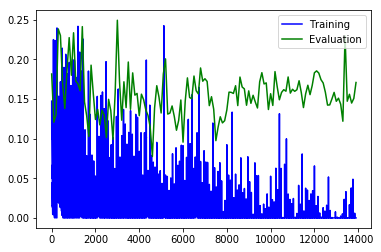

TEST DEBUG : 7 mismatches found at indices [ 6  7  9 12 16 17 18]
TEST DEBUG : Testing image at index 6


NameError: name 'cv' is not defined

In [21]:
# Network configurations dictionary
net_config = {
    "data": {
        "dir_name": "../../Data/5_Fingers",
        "x_name": "X.npy",
        "y_name": "Y.npy",
        "one_hot_index": -1,
        "dist_train_dev_test": (900, 0, 21)
    },
    "nn_arc": {
        "layers": (100, 50, 50, 50, 5, 1),
        "activations": [tanh, tanh, relu, relu, relu, sigmoid]
    },
    "hyperparameters": {    # For tuning
        "training_iterations": 100,
        "iter_limit": 13901,
        "debug_num_iter": 100,
        "learning_rate": 0.03,
        "regularization_parameter": 0.01,
        "num_epochs": 80,
        "mini_batch_size": 30,
        "threshold": 0.9,
        "dropoff_keep": 1.0
    },
    "testing": {
        "test_image": "../../Data/5_Fingers/Test.jpg",  # Needed
        "false_examples": "../../DataCollector/Mask_data_collector/Data_Distributions_Backups/"
                          "Data_Distribution_5_Fingers/Data_Distribution_Generated/False",  # No need for this
        "true_examples": "../../DataCollector/Mask_data_collector/Data_Distributions_Backups/"
                         "Data_Distribution_5_Fingers/Data_Distribution_Generated/True",    # No need for this
        "show_mismatches": True,  # No need for this
        "live_trial_mode": True   # No need for this
    }
}

if __name__ == '__main__':
    # Load data into memory
    X, Y = load_dataset(dataset_dir_name=net_config["data"]["dir_name"], x_name=net_config["data"]["x_name"],
                        y_name=net_config["data"]["y_name"], one_hot_index=net_config["data"]["one_hot_index"])
    datasets = split_train_dev_test(X, Y, net_config["data"]["dist_train_dev_test"])
    X_train, Y_train = datasets["train"]
    X_dev, Y_dev = datasets["dev"]
    X_test, Y_test = datasets["test"]
    # Load weights and activation functions
    nn_architecture = {
        "layers": net_config["nn_arc"]["layers"],
        "activations": net_config["nn_arc"]["activations"]
    }
    architecture_nn, params = init_params_deep(X.shape[0], nn_architecture["layers"])
    activations = nn_architecture["activations"]
    # Training the network
    # Hyperparameters
    num_iter = net_config["hyperparameters"]["training_iterations"]
    debug_iter_num = net_config["hyperparameters"]["debug_num_iter"]
    learning_rate = net_config["hyperparameters"]["learning_rate"]
    reg_param_lambda = net_config["hyperparameters"]["regularization_parameter"]
    num_epochs = net_config["hyperparameters"]["num_epochs"]
    mini_batch_size = net_config["hyperparameters"]["mini_batch_size"]
    dropoff_prob = net_config["hyperparameters"]["dropoff_keep"]
    cost_tracker = {
        "train_x": [],
        "train_cost": [],
        "eval_x": [],
        "eval_cost": []
    }
    print("TRAIN DEBUG : {it} training iterations required, iteration limit is {iter_limit}".format(
        it=int(num_iter * num_epochs * X_train.shape[1] / mini_batch_size),
        iter_limit=net_config["hyperparameters"]["iter_limit"]
    ))

    # Main training process
    try:
        for train_iter_num in range(num_iter):
            X_training, Y_training = shuffle_dataset(X_train, Y_train)
            (X_training_batches, Y_training_batches) = divide_into_mini_batches(X_training, Y_training, mini_batch_size)
            num_batches = len(Y_training_batches)
            for batch_index in range(len(Y_training_batches)):
                X_training_batch = X_training_batches[batch_index]
                Y_training_batch = Y_training_batches[batch_index]
                for epoch_count in range(num_epochs):
                    # Forward Propagate
                    Y_pred_mini_batch, cache_mini_batch = forward_propagate_deep(params, activations,
                                                                                 X_training_batch)
                    # Note the cost
                    cost_iter = cost_function(Y_pred_mini_batch, Y_training_batch)
                    i = train_iter_num * num_batches * num_epochs + batch_index * num_epochs + epoch_count
                    cost_tracker["train_x"].append(i)
                    cost_tracker["train_cost"].append(cost_iter)
                    if i % debug_iter_num == 0 or i == 0:
                        pred_test, _ = forward_propagate_deep(params, activations, X_test)
                        eval_cost = cost_function(pred_test, Y_test)
                        cost_tracker["eval_x"].append(i)
                        cost_tracker["eval_cost"].append(eval_cost)
                        print("TRAIN DEBUG : Cost at iteration {it_num} is {cost}\t Test cost is {test_cost}".format(
                            cost=cost_iter, it_num=i, test_cost=eval_cost))
                    # Back propagation
                    params = back_propagation_deep(cache_mini_batch, params, activations, Y_training_batch,
                                                   learning_rate, reg_param_lambda)
                    if net_config["hyperparameters"]["iter_limit"] is not None:
                        if i == net_config["hyperparameters"]["iter_limit"]:
                            raise StopIteration
    except StopIteration:
        print("TRAIN DEBUG : Iterations have stopped at {i_num}".format(i_num=i))

    # print(params)
    # print(forward_propagate_deep(params, activations, X))

    plt.plot(cost_tracker["train_x"], cost_tracker["train_cost"], 'b-',
             cost_tracker["eval_x"], cost_tracker["eval_cost"], 'g-')
    plt.legend(["Training", "Evaluation"])
    plt.show()
    # Test segment
    error_test_set(X_test, Y_test, params, activations,
                   show_mismatch_images=bool(net_config["testing"]["show_mismatches"]))